In [1]:
import numpy as np
import pandas as pd
import random
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
%matplotlib inline

import qiskit
# from qiskit.visualization import
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
from qiskit.tools.visualization import plot_state_city, plot_bloch_multivector, plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity, DensityMatrix
# from qiskit.quantum_info.random.utils import random_state
from qiskit.providers.aer import noise

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
# import qiskit.ignis.mitigation.measurement as mc

# readout calibration
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [2]:
from qiskit import IBMQ
# loading roel's account
# IBMQ.save_account('30c393d587101bddd683187f32510459f5c95e4d0afdf3da7ba96f18262de522fab6749335cb7504cc72eebf25110567ee03e7ea2ba29b644a3ab9e5a03a56f2')
# IBMQ.active_account() # to check what account is active
ibmq_provider = IBMQ.load_account()        # credentials stored on disk
simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
simulator_noise = ibmq_provider.get_backend('ibmq_qasm_simulator')
device = ibmq_provider.get_backend('ibmqx2') #ibmq_burlington ibmq_16_melbourne ibmq_ourense
properties = device.properties()
noise_model = noise.device.basic_device_noise_model(properties)
coupling_map = device.configuration().coupling_map
basis_gates = noise_model.basis_gates

C:\Users\Niels\Envs\dev_qiskit\lib\site-packages\qiskit\providers\aer\noise\device\basic_device_model.py:112: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


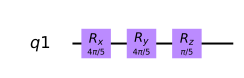

In [3]:
R=[]
n=3
qreg = QuantumRegister(n)
for i in range(3):
    R.append(random.randint(1,10))
qreg_exp = QuantumRegister(1)
qc_expected = QuantumCircuit(qreg_exp)
qc_expected.rx(np.pi/5*R[0],0)
qc_expected.ry(np.pi/5*R[1],0)
qc_expected.rz(np.pi/5*R[2],0)
qc_expected.draw(output='mpl')

The expected state is: [ 0.90953518+0.j         -0.02155988-0.41506737j]


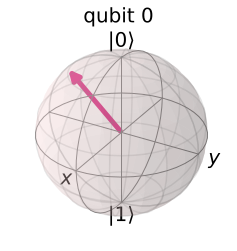

In [4]:
job = qiskit.execute(qc_expected, Aer.get_backend('statevector_simulator'))
psi_expected = job.result().get_statevector(qc_expected)
print('The expected state is:', psi_expected)
plot_bloch_multivector(psi_expected)

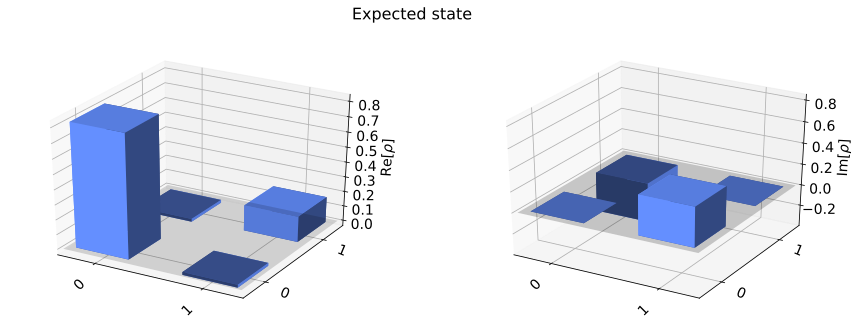

In [5]:
plot_state_city(psi_expected, title='Expected state')

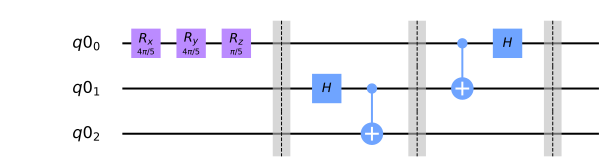

In [6]:
qc = QuantumCircuit(qreg)
qc.rx(np.pi/5*R[0],0)
qc.ry(np.pi/5*R[1],0)
qc.rz(np.pi/5*R[2],0)
qc.barrier()
qc.h(1)
qc.cx(1,2)
qc.barrier()
qc.cx(0,1)
qc.h(0)
qc.barrier()
qc.draw(output='mpl')

In [7]:
#readout calibration measurements
cal_circuits, state_labels = complete_meas_cal(qr = qc.qregs[0], circlabel = 'measerrormitcal')
cal_job = qiskit.execute(cal_circuits,backend = device,shots = 8192, optimization_level = 0)
job_monitor(cal_job)
calres = cal_job.result()

Job Status: job has successfully run


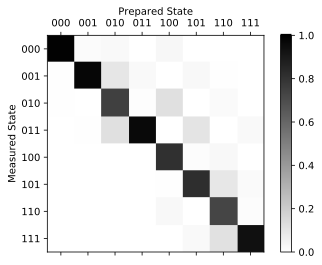

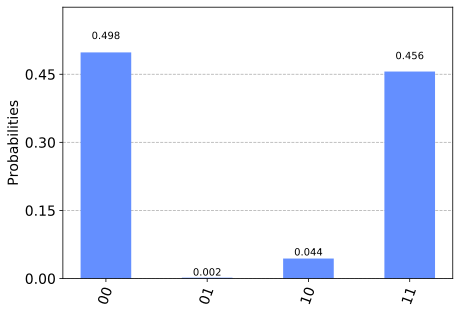

In [8]:
meas_fitter = CompleteMeasFitter(calres, state_labels)
meas_fitter.plot_calibration()
# meas_filter = meas_fitter.filter
counts =[0,0,0,0,0,0,0,0]
bits = [ '000', '100', '001', '101', '010', '110', '011', '111']
for i in range(0,8):
    counts[i]=calres.get_counts(cal_circuits[i])
    for bit in bits:
        if bit not in counts[i]:
            counts[i][bit] = 0
countsdev = {'00':counts[0]["000"]+counts[0]["001"]+counts[0]["010"]+counts[0]["011"]+
             counts[1]["000"]+counts[1]["001"]+counts[1]["010"]+counts[1]["011"]+
             counts[2]["000"]+counts[2]["001"]+counts[2]["010"]+counts[2]["011"]+
             counts[3]["000"]+counts[3]["001"]+counts[3]["010"]+counts[3]["011"],
             '01':counts[0]["100"]+counts[0]["101"]+counts[0]["110"]+counts[0]["111"]+
             counts[1]["100"]+counts[1]["101"]+counts[1]["110"]+counts[1]["111"]+
             counts[2]["100"]+counts[2]["101"]+counts[2]["110"]+counts[2]["111"]+
             counts[3]["100"]+counts[3]["101"]+counts[3]["110"]+counts[3]["111"],
             '10':counts[4]["000"]+counts[4]["001"]+counts[4]["010"]+counts[4]["011"]+
             counts[5]["000"]+counts[5]["001"]+counts[5]["010"]+counts[5]["011"]+
             counts[6]["000"]+counts[6]["001"]+counts[6]["010"]+counts[6]["011"]+
             counts[7]["000"]+counts[7]["001"]+counts[7]["010"]+counts[7]["011"],
             '11':counts[4]["100"]+counts[4]["101"]+counts[4]["110"]+counts[4]["111"]+
             counts[5]["100"]+counts[5]["101"]+counts[5]["110"]+counts[5]["111"]+
             counts[6]["100"]+counts[6]["101"]+counts[6]["110"]+counts[6]["111"]+
             counts[7]["100"]+counts[7]["101"]+counts[7]["110"]+counts[7]["111"]}
epsilon01=countsdev["01"]/(8192*8)
epsilon10=countsdev["10"]/(8192*8)
beta0=(epsilon10-epsilon01)
beta1=1-epsilon10-epsilon01
plot_histogram(countsdev)

In [9]:
# beta0 = 0.049624
# beta1 = 0.946625
print('The value of beta 0:', beta0)
print('The value of beta 1:', beta1)

# The value of beta 0: 0.04475
# The value of beta 1: 0.951125

The value of beta 0: 0.04217529296875
The value of beta 1: 0.954193115234375


In [10]:
# defining the tomography circuits of interest (just need ZZX, ZZY, ZZZ)
qst_full_circuits = state_tomography_circuits(qc,qreg)
qst_circuit = [qst_full_circuits[24], qst_full_circuits[25], qst_full_circuits[26]]

In [23]:
backends = [simulator, simulator_noise, device]
paulis = [('Z','Z','X'), ('Z','Z','Y'), ('Z','Z','Z')]
basis = ['X', 'Y', 'Z']
for be in range(len(backends)):
    state = {'X': {'0': 0, '1': 0}, 'Y': {'0': 0, '1': 0}, 'Z': {'0': 0, '1': 0}}
    state_df = pd.DataFrame(data=[state,state,state,state])

    if be == 0:
        job_sim = qiskit.execute(qst_circuit, backends[0], shots=8192) # for ideal simulator
        tom = StateTomographyFitter(job_sim.result(), qst_circuit)
    if be == 1:
        job_sim = qiskit.execute(qst_circuit, backends[1], shots=8192,noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)
        tom = StateTomographyFitter(job_sim.result(), qst_circuit)
    if be == 2:
        job_dev = qiskit.execute(qst_circuit, backends[2], shots=8192)
        job_monitor(job_dev)
        tom = StateTomographyFitter(job_dev.result(), qst_circuit)

    for pauli in paulis:
        for bit in bits:
            if bit not in tom.data[pauli]:
                tom.data[pauli][bit]=0
    for i in range(4):
        for j in range(3):
            state_df.loc[i][basis[j]] = {'0': tom.data[(paulis[j])][bits[2*i]],
                                         '1': tom.data[(paulis[j])][bits[2*i+1]]}

    if be == 0:
        state_sim = state_df
        print('The full state for the simulator is', state_sim)
    if be == 1:
        state_sim_noise = state_df
        print('The full state for the simulator is', state_sim_noise)
    if be == 2:
        state_dev = state_df
        print('The full state for the device is', state_dev)

{('Z', 'Z', 'X'): {'000': 973, '101': 974, '010': 966, '111': 962, '001': 1080, '011': 1094, '100': 1085, '110': 1058}, ('Z', 'Z', 'Y'): {'000': 246, '101': 239, '010': 1785, '111': 1782, '001': 1765, '011': 261, '100': 1846, '110': 268}, ('Z', 'Z', 'Z'): {'000': 1685, '101': 349, '010': 344, '111': 1678, '001': 1702, '011': 331, '100': 401, '110': 1702}}
The full state for the simulator is                        X                      Y                      Z
0  {'0': 973, '1': 1085}  {'0': 246, '1': 1846}  {'0': 1685, '1': 401}
1  {'0': 1080, '1': 974}  {'0': 1765, '1': 239}  {'0': 1702, '1': 349}
2  {'0': 966, '1': 1058}  {'0': 1785, '1': 268}  {'0': 344, '1': 1702}
3  {'0': 1094, '1': 962}  {'0': 261, '1': 1782}  {'0': 331, '1': 1678}
{('Z', 'Z', 'X'): {'000': 1067, '101': 988, '010': 973, '111': 915, '001': 1096, '011': 1052, '100': 1074, '110': 1027}, ('Z', 'Z', 'Y'): {'000': 370, '101': 329, '010': 1727, '111': 1702, '001': 1746, '011': 331, '100': 1694, '110': 293}, ('Z', 'Z', 

In [12]:
# fidelity processing for sim and dev
Iden = np.matrix('1, 0; 0, 1')
XPaul = np.matrix('0, 1; 1, 0')
YPaul = np.matrix('0, 0-1j; 0+1j, 0')
ZPaul = np.matrix('1, 0; 0, -1')

r_sim = np.zeros((4, 3))
r_sim_noise = np.zeros((4, 3))
r_dev = np.zeros((4, 3))
for i in range(4):
    for j in range(3):
        r_sim[i,j] = (state_sim[basis[j]][i]['0']*1 + state_sim[basis[j]][i]['1']*(-1))/(state_sim[basis[j]][i]['0'] + state_sim[basis[j]][i]['1'])
        r_sim_noise[i,j] = (state_sim_noise[basis[j]][i]['0']*1 + state_sim_noise[basis[j]][i]['1']*(-1))/(state_sim_noise[basis[j]][i]['0'] + state_sim_noise[basis[j]][i]['1'])
        r_dev[i,j] = (state_dev[basis[j]][i]['0']*1 + state_dev[basis[j]][i]['1']*(-1))/(state_dev[basis[j]][i]['0'] + state_dev[basis[j]][i]['1'])
        
r_cor = np.zeros((4,3))
r_cor[:,:] = (r_dev[:,:] - beta0) / beta1
        
rho_sim = [0,0,0,0]
rho_sim_noise = [0,0,0,0]
rho_dev = [0,0,0,0]
rho_cor = [0,0,0,0]

for i in range(4):
    rho_sim[i] = (1/2)*(Iden+r_sim[i,0]*XPaul+r_sim[i,1]*YPaul+r_sim[i,2]*ZPaul)
    rho_sim_noise[i] = (1/2)*(Iden+r_sim_noise[i,0]*XPaul+r_sim_noise[i,1]*YPaul+r_sim_noise[i,2]*ZPaul)
    rho_dev[i] = (1/2)*(Iden+r_dev[i,0]*XPaul+r_dev[i,1]*YPaul+r_dev[i,2]*ZPaul)
    rho_cor[i] = (1/2)*(Iden+r_cor[i,0]*XPaul+r_cor[i,1]*YPaul+r_cor[i,2]*ZPaul)
    
rho = pd.DataFrame(data=[rho_sim, rho_sim_noise, rho_dev, rho_cor])
for ind in range(4):
    rho.loc[ind][1] = ZPaul @ rho.loc[ind][1] @ ZPaul
    rho.loc[ind][2] = XPaul @ rho.loc[ind][2] @ XPaul
    rho.loc[ind][3] = ZPaul @ XPaul @ rho.loc[ind][3] @ XPaul @ ZPaul

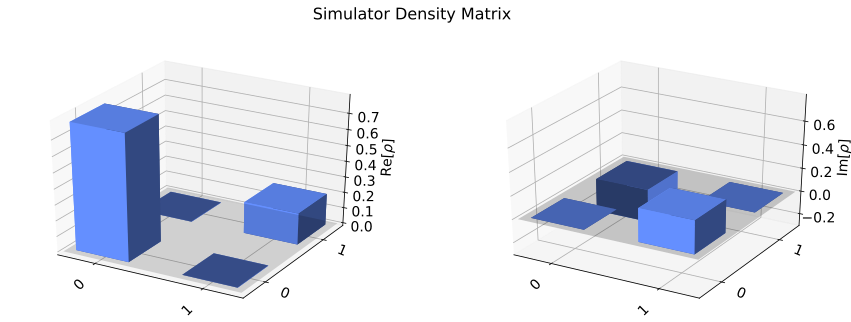

In [33]:
finstate= rho[3][3]
plot_state_city(finstate, title='Simulator Density Matrix')

In [13]:
Fidelity = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        Fidelity[i,j] = state_fidelity(psi_expected, rho[j][i], validate=False)
        
F = np.mean(Fidelity,axis=1)
print('Simulator Fidelity:', F[0])
print('Noisy Simulator Fidelity:', F[1])
print('Device Fidelity:', F[2])
print('Corrected Device Fidelity:', F[3])

Simulator Fidelity: 1.0018912250411556
Noisy Simulator Fidelity: 0.956493342842792
Device Fidelity: 0.8892416072847629
Corrected Device Fidelity: 0.9079274950429242


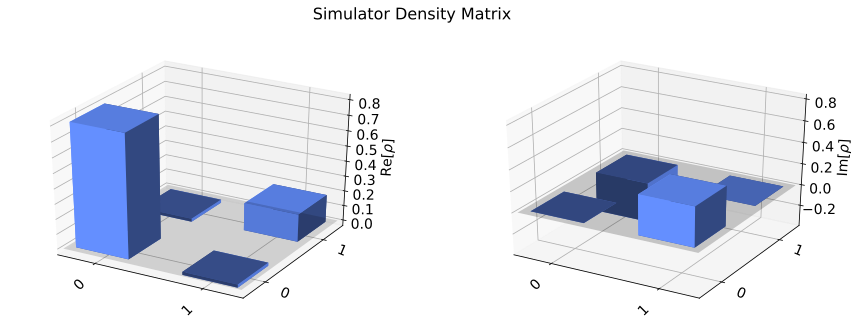

In [14]:
plot_state_city(rho[0][0], title='Simulator Density Matrix')

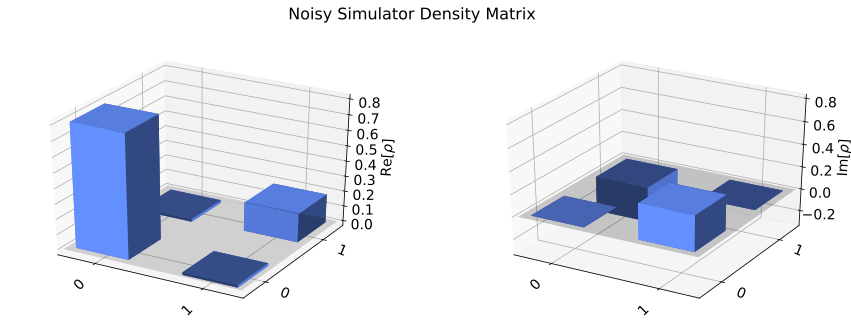

In [15]:
plot_state_city(rho[0][1], title='Noisy Simulator Density Matrix')

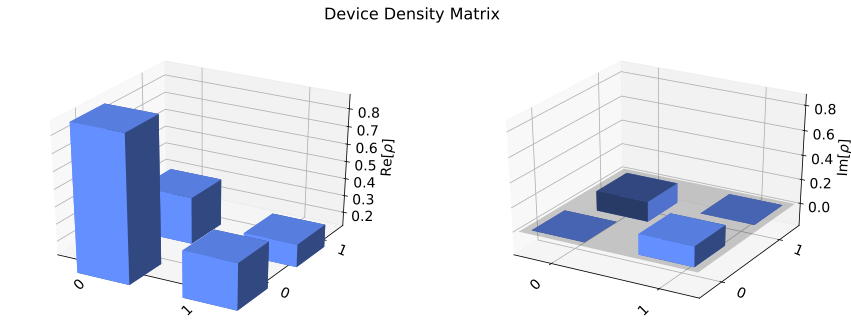

In [16]:
plot_state_city(rho[0][2], title='Device Density Matrix')

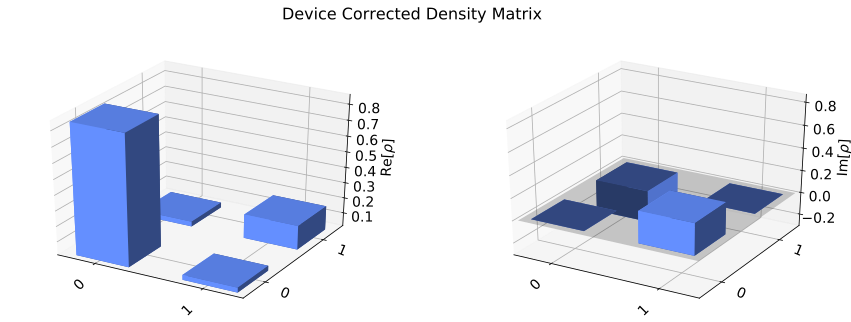

In [38]:
plot_state_city(rho[2][3], title='Device Corrected Density Matrix')

In [18]:
# checking validity of the density matrices, little problem with the simulator one...

rho_sim = DensityMatrix(rho[0][0])
rho_dev = DensityMatrix(rho[0][1])

In [19]:
print('Is the simulator density matrix valid?', rho_sim.is_valid())
print('Is the device density matrix valid?', rho_dev.is_valid())

Is the simulator density matrix valid? True
Is the device density matrix valid? True


In [20]:
import qiskit.tools.jupyter
%qiskit_version_table